### **Columbia University**
### **ECBM E4040 Neural Networks and Deep Learning. Fall 2021.**

## **Task 2: RNN application -- Tweet Sentiment Analysis**

In this task, you are going to classify the sentiment in tweets into positive and negative using an LSTM model. The code to load the data and see its characteristics has been provided to you. 

In the first task, you will encode the data using using one hot encoding and train an LSTM network to classify the sentiment. In the second task, you will replace the one hot encoding with an embedding layer and train another LSTM model. You will then extract the trained embeddings and visualize the word embeddings in 2 dimensions by using TSNE for dimenssionality redution. 

In [2]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load Data


In [3]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## **Part 1 LSTM Encoder**

**TODO**: Create a single-layer LSTM network to classify tweets. Use one hot encoding to represent each word in the tweet. Set LSTM units to 100. Use Adam optimizer and set batch size to 64.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional). 

(tf.one_hot and Keras functional API may be useful).

In [268]:
# train_tweets.shape, train_labels.shape
np.max(train_tweets), np.min(train_tweets)
print("dictionary size = " ,np.max(train_tweets)-np.min(train_tweets)+1)

dictionary size =  7596


In [269]:
###################################################
# TODO: Create a single-layer LSTM network.       #
#                                                 #
###################################################

from tensorflow.keras.layers import LSTM, Dense, Activation, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras.layers import Layer
from time import time

class OneHot_Layer(Layer):

    def __init__(self, **kwargs):
        self.output_dim = 7596
        super(OneHot_Layer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(OneHot_Layer, self).build(input_shape)  

    def call(self,x):
        # print(x, x.dtype)
        # return tf.one_hot(tf.cast(x, dtype="int32"), depth = 7596)
        return tf.one_hot(x, depth = 7596) 

model_LSTM = tf.keras.Sequential()
# model_LSTM.add(LSTM(5, return_sequences=True, return_state=True))
model_LSTM.add(Input(shape = (20,),dtype="int32"   ))
model_LSTM.add(OneHot_Layer())
model_LSTM.add(LSTM(100))
model_LSTM.add(Dense(64,"relu"))
model_LSTM.add(Dense(2))


model_LSTM.summary() 
model_LSTM.compile(
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # loss="categorical_crossentropy",
              optimizer=Adam(0.001),
              metrics=['accuracy']) 

t0 = time()

history_LSTM = model_LSTM.fit(train_tweets,tf.one_hot(train_labels, depth = 2) , batch_size=64, epochs=5) 

t1 = time()
print("time: %.2g sec" % ( t1 - t0))



###################################################
# END TODO                                        #
###################################################

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 one_hot__layer_17 (OneHot_L  (None, 20, 7596)         0         
 ayer)                                                           
                                                                 
 lstm_55 (LSTM)              (None, 100)               3078800   
                                                                 
 dense_114 (Dense)           (None, 64)                6464      
                                                                 
 dense_115 (Dense)           (None, 2)                 130       
                                                                 
Total params: 3,085,394
Trainable params: 3,085,394
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
938/938 [==============================] - 139s 147ms/step - loss: 0.5327 - accuracy: 0.7294
Epoch 

In [270]:
model_LSTM.evaluate(test_tweets,tf.one_hot(test_labels,2))

32/32 [==============================] - 2s 40ms/step - loss: 0.5868 - accuracy: 0.7570


[0.5868360996246338, 0.7570000290870667]

## **Part 2: Embedding Lookup layer**

**Define an embedding layer**

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling.

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness).

**TODO**: Define a similar model as above with one change. Use an Embedding layer instead of one hot embedding. Also, write a custom training loop to train the model instead of using model.fit(). Writing a custom loop gives you complete control over how the model is trained. Refer to the link below.

https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

Report loss and accuracy for training and validation after each epoch. Also, display the loss value after every 400 steps. 

Do you see any difference in accuracy? What about training time? What inference can you draw?


Solution:

In [271]:
###################################################
# TODO: Create a single-layer LSTM network        #
#       using Embedding layer                     #
###################################################



# already imported in last cell
# import keras
# from keras.layers import LSTM, Dense, Activation, Input
# from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
# from keras.layers import Layer

from tensorflow.keras.layers import Embedding 
from tensorflow.keras.models import Model
from time import time

batch_size = 400
def create_model():
    
    tweets_input = Input(shape=(20,))
    x = Embedding(7597, 300, input_length=20)(tweets_input)
    x = LSTM(100)(x)
    x = Dense(64,"relu")(x)
    out = Dense(2)(x)  # notice loss
    model = Model(tweets_input, out)

    return model


model_LSTM_embedding = create_model()

# @tf.function
def custom_train(model,train_tweets,y_train, batch_size = 64, epochs=7):
    
    t0 = time()
    train_dataset = tf.data.Dataset.from_tensor_slices((train_tweets,y_train))
    train_dataset = train_dataset.batch(batch_size)

    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # metrics_fn=tf.keras.metrics.BinaryAccuracy()
    metrics_fn=tf.keras.metrics.CategoricalAccuracy()

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            # print(step, x_batch_train.shape, y_batch_train.shape)

            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)  # Logits for this minibatch
                loss_value = loss_fn(y_batch_train, logits)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))            
            metrics_fn.update_state(y_batch_train,logits)
            
            train_acc = metrics_fn.result()            
            metrics_fn.reset_states()

            # Log every 400 batches.
            if (step+1) % 400 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f with train_acc %.4f"
                    % (step+1, float(loss_value),float(train_acc) )
                )
    t1 = time()
    print("time: %.2g sec" % ( t1 - t0))
    
                    
custom_train(model_LSTM_embedding,train_tweets,tf.one_hot(train_labels,2) )



###################################################
# END TODO                                        #
###################################################


Start of epoch 0
Training loss (for one batch) at step 400: 0.4138 with train_acc 0.8281
Training loss (for one batch) at step 800: 0.5720 with train_acc 0.6719

Start of epoch 1
Training loss (for one batch) at step 400: 0.3742 with train_acc 0.8281
Training loss (for one batch) at step 800: 0.5277 with train_acc 0.7344

Start of epoch 2
Training loss (for one batch) at step 400: 0.3220 with train_acc 0.8438
Training loss (for one batch) at step 800: 0.4661 with train_acc 0.7500

Start of epoch 3
Training loss (for one batch) at step 400: 0.2800 with train_acc 0.8750
Training loss (for one batch) at step 800: 0.3880 with train_acc 0.8125

Start of epoch 4
Training loss (for one batch) at step 400: 0.2692 with train_acc 0.8750
Training loss (for one batch) at step 800: 0.3829 with train_acc 0.8281

Start of epoch 5
Training loss (for one batch) at step 400: 0.2868 with train_acc 0.8750
Training loss (for one batch) at step 800: 0.3121 with train_acc 0.8750

Start of epoch 6
Training l

In [272]:
model_LSTM_embedding.compile(
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # loss="categorical_crossentropy",
              optimizer=Adam(0.001),
              metrics=tf.keras.metrics.BinaryAccuracy()) 

model_LSTM_embedding.evaluate(test_tweets,tf.one_hot(test_labels,2))

32/32 [==============================] - 0s 6ms/step - loss: 0.8548 - binary_accuracy: 0.7325


[0.8547804355621338, 0.7325000166893005]

Time cost lower

## **TODO:**  **Visualize word vectors via tSNE**

First, you need to retrieve embedding matrix from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector.

And then, you should visualize some interesting word pairs in 2D panel. You may find scatter function in matplotlib.pyplot useful.

Hint: You can use TSNE tool provided in scikit-learn. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., conda install nomkl numpy scipy scikit-learn numexpr.

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.

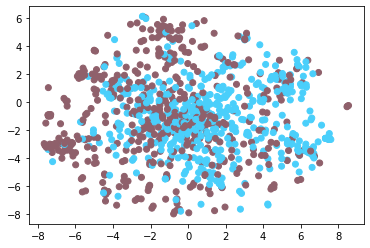

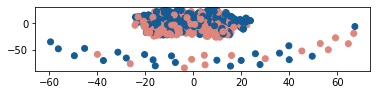

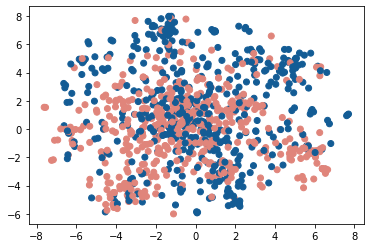

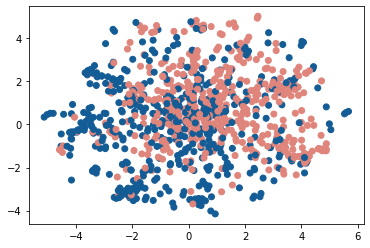

In [273]:
###################################################
# TODO: Visualize word vectors using TSNE.        #
#                                                 #
###################################################

# X = model_LSTM_1.layers[1](test_tweets)   # test_tweets.shape (1000, 20);  X.shape  TensorShape([1000, 20, 300])
# X_low_vector = X.numpy().reshape((1000,-1)) # X_low_vector.shape  (1000, 6000)


# import numpy as np
# from sklearn.manifold import TSNE

# Y_tsne = TSNE(n_components=2,perplexity=30, learning_rate='auto',init='random').fit_transform(X_low_vector)
# # Y_tsne.shape  (1000, 2)

# labels = test_labels
# # labels.shape  (1000,)
# colors = np.random.rand(2,3)
# color_labels = [colors[int(i)] for i in labels.tolist()]
# plt.scatter(Y_tsne[:,0], Y_tsne[:,1], c =color_labels)
# plt.show()


X = model_LSTM_embedding.layers[1](test_tweets)   # test_tweets.shape (1000, 20);  X.shape  TensorShape([1000, 20, 300])
X_low_vector = X.numpy().reshape((1000,-1)) # X_low_vector.shape  (1000, 6000)


import numpy as np
from sklearn.manifold import TSNE

Y_tsne = TSNE(n_components=2,perplexity=30, learning_rate='auto',init='random').fit_transform(X_low_vector)
# Y_tsne.shape  (1000, 2)

labels = test_labels
# labels.shape  (1000,)
colors = np.random.rand(2,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y_tsne[:,0], Y_tsne[:,1], c =color_labels)
plt.show()



perplexities = [10,30,50]
fig1 = plt.figure()
colors = np.random.rand(2,3)

for i, perplexity in enumerate(perplexities):
    ax = fig1.add_subplot(3,1, i + 1)
    
    Y_tsne = TSNE(n_components=2,perplexity=perplexity, learning_rate='auto',init='random').fit_transform(X_low_vector)
    # Y_tsne.shape  (1000, 2)

    labels = test_labels
    # labels.shape  (1000,)
    
    color_labels = [colors[int(i)] for i in labels.tolist()]
    plt.scatter(Y_tsne[:,0], Y_tsne[:,1], c =color_labels)
    plt.show()



###################################################
# END TODO                                        #
###################################################

men =  1397
queen =  1843
king =  2022
women =  2173
female =  3899
male =  4911
(38, 20) (38,) 
 (23, 20) (23,) 
 (26, 20) (26,) 
 (30, 20) (30,) 
 (12, 20) (12,) 
 (8, 20) (8,)


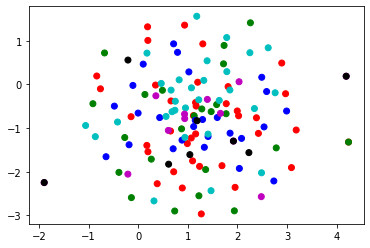

In [274]:
# for word pairs 

for i, word in enumerate(vocabulary):
    if(word == "female"):
        print("female = ",i)
    if(word == "male"):
        print("male = ", i)
    if(word == "king"):
        print("king = ", i)
    if(word == "men"):
        print("men = ",i)
    if(word ==  "queen"):
        print("queen = ", i)
    if(word == "women"):
        print("women = ", i)


def if_word_in_tweet(word_index,word_list):
    for i in word_list:
        if(i==word_index):
            return True
    return False

men_tweets = []
women_tweets = []
king_tweets = []
queen_tweets = []
female_tweets = []
male_tweets = []


men_labels = []
women_labels = []
king_labels = []
queen_labels = []
female_labels = []
male_labels = []

for index, tweet in enumerate(train_tweets):
    ## men
    if(if_word_in_tweet(1397, tweet)):
        men_tweets.append(tweet)
        men_labels.append(train_labels[index])
        
    ## queen
    if(if_word_in_tweet(1843, tweet)):
        queen_tweets.append(tweet)
        queen_labels.append(train_labels[index])

    ## king
    if(if_word_in_tweet(2022, tweet)):
        king_tweets.append(tweet)
        king_labels.append(train_labels[index])
    
    ## women
    if(if_word_in_tweet(2173, tweet)):
        women_tweets.append(tweet)
        women_labels.append(train_labels[index])
        
    ## female
    if(if_word_in_tweet(3899, tweet)):
        female_tweets.append(tweet)
        female_labels.append(train_labels[index])
        
    ## male
    if(if_word_in_tweet(4911, tweet)):
        male_tweets.append(tweet)
        male_labels.append(train_labels[index])

# men =  1397
# queen =  1843
# king =  2022
# women =  2173
# female =  3899
# male =  4911

##
men_tweets = np.array(men_tweets)
women_tweets = np.array(women_tweets)
king_tweets = np.array(king_tweets)
queen_tweets = np.array(queen_tweets)
female_tweets = np.array(female_tweets)
male_tweets = np.array(male_tweets)

men_labels = np.array(men_labels)
women_labels = np.array(women_labels)
king_labels = np.array(king_labels)
queen_labels = np.array(queen_labels)
female_labels = np.array(female_labels)
male_labels = np.array(male_labels)


print(men_tweets.shape, men_labels.shape,"\n",
      women_tweets.shape, women_labels.shape,"\n",
      king_tweets.shape, king_labels.shape,"\n",
      queen_tweets.shape, queen_labels.shape,"\n",
      female_tweets.shape,female_labels.shape,"\n",
      male_tweets.shape, male_labels.shape)


X_few_words = np.vstack((men_tweets, 
                        women_tweets, 
                        king_tweets, 
                        queen_tweets,
                        female_tweets,
                        male_tweets))
# X_few_words.shape (137, 20)

few_words_labels = np.hstack((men_labels, 
                        women_labels,  
                        king_labels,  
                        queen_labels, 
                        female_labels, 
                        male_labels))
# few_words_labels.shape (137,)

X = model_LSTM_embedding.layers[1](X_few_words)   # train_tweets.shape  (137, 20)
X_low_vector = X.numpy().reshape((137,-1)) # X_low_vector.shape  
Y_tsne = TSNE(n_components=2,perplexity=30, learning_rate='auto',init='random').fit_transform(X_low_vector) # Y_tsne.shape  (137, 2)

cr = []
for i in range(38):
    cr.append("r")  
for i in range(23):
    cr.append("g")
for i in range(26):
    cr.append("b")
for i in range(30):
    cr.append("c")
for i in range(12):
    cr.append("m")
for i in range(8):
    cr.append("k")


labels = few_words_labels # labels.shape  (137,)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y_tsne[:,0], Y_tsne[:,1],c =cr ,  cmap='viridis') # cmap=plt.cm.Spectral
plt.show()

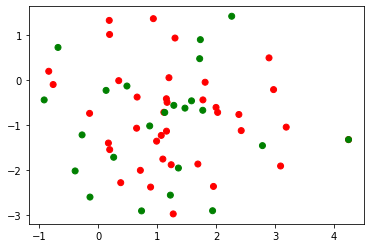

In [275]:
# word pair: women/men
labels = few_words_labels[:61]
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y_tsne[:61,0], Y_tsne[:61,1],c =cr[:61] ,  cmap='viridis') # cmap=plt.cm.Spectral
plt.show()

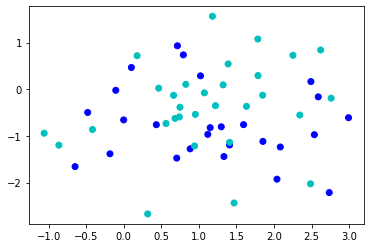

In [276]:
# word pair: king/queen
labels = few_words_labels[61:117]
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y_tsne[61:117,0], Y_tsne[61:117,1],c =cr[61:117] )
plt.show()

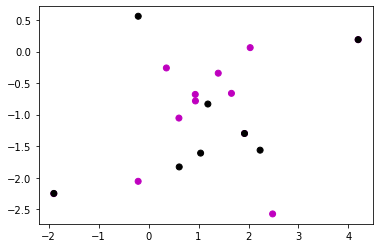

In [277]:
# word pair: female/male
labels = few_words_labels[117:137] 
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y_tsne[117:137,0], Y_tsne[117:137,1],c =cr[117:137] )
plt.show()